In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mypackage import Strategy_Manager, Strategy, Backtester, compare_results, strategy, DataFileReader

filepath = 'data.parquet'
filepath = 'fichier_donnée.csv'

# Initialiser le lecteur de fichiers
reader = DataFileReader()

# Utilisation basique - détection automatique de la colonne de date
#data = reader.read_file(filepath)

# Ou en spécifiant la colonne de date facultatif
# Ou en spécifiant un format de date particulier
reader = DataFileReader(date_format='%d/%m/%Y')
data = reader.read_file(filepath, date_column='Date_Price')
print('ok')

ok


In [2]:

# Création d'une stratégie par héritage
class MovingAverageCrossover(Strategy):
    
    def __init__(self, short_window=20, long_window=50, rebalancing_frequency='D'):
        super().__init__(rebalancing_frequency=rebalancing_frequency)
        self.short_window = short_window
        self.long_window = long_window

    def get_position(self, historical_data, current_position):
        if len(historical_data) < self.long_window:
            return np.nan
        
        short_ma = historical_data[data.columns[0]].rolling(self.short_window).mean()
        long_ma = historical_data[data.columns[0]].rolling(self.long_window).mean()
        
        return 1 if short_ma.iloc[-1] > long_ma.iloc[-1] else -1

# Création d'une stratégie simple avec décorateur
@strategy
def momentum_strategy(historical_data, current_position, rebalancing_frequency, chosen_window=20):
    """
    Calcule un signal de trading basé sur le momentum.
    
    Args:
        historical_data: DataFrame avec les données historiques
        current_position: Position actuelle
        rebalancing_frequency: Fréquence de rebalancemen
        t
        chosen_window: Fenêtre de calcul du momentum (défaut: 20 périodes)
    
    Returns:
        int: 1 pour position longue, -1 pour position courte
    """
    if len(historical_data) < chosen_window:
        return 0
    
    returns = historical_data[historical_data.columns[0]].pct_change(chosen_window)
    return 1 if returns.iloc[-1] > 0 else -1

class VolatilityBasedStrategy(Strategy):
    """Stratégie basée sur la volatilité."""
    
    def __init__(self, volatility_threshold=0.02, window_size=10, rebalancing_frequency='D'):
        super().__init__(rebalancing_frequency=rebalancing_frequency)
        self.volatility_threshold = volatility_threshold
        self.window_size = window_size
        self.volatility = None

    def fit(self, data: pd.DataFrame) -> None:
        """
        Calcule la volatilité sur une fenêtre donnée.
        
        Args:
            data: DataFrame contenant les données historiques avec une colonne 'price'.
        """
        # if 'price' not in data.columns:
        #     raise ValueError("Les données historiques doivent contenir une colonne 'price'.")
        
        # Calculer les rendements journaliers
        daily_returns = data[data.columns[0]].pct_change()
        
        # Calculer la volatilité sur la fenêtre définie
        self.volatility = daily_returns.rolling(window=self.window_size).std()
    
    def get_position(self, historical_data: pd.DataFrame, current_position: float) -> float:
        """
        Détermine la position en fonction de la volatilité.
        
        Args:
            historical_data: DataFrame avec les données historiques.
            current_position: Position actuelle.
        
        Returns:
            float: Position désirée (-1 pour vendre, 1 pour acheter, 0 pour neutre).
        """
        if self.volatility is None:
            raise ValueError("La méthode fit() doit être appelée avant get_position().")
        
        # Vérifier la dernière valeur de volatilité
        current_volatility = self.volatility.iloc[-1]
        if current_volatility is None or pd.isna(current_volatility):
            return 0.0  # Neutre si volatilité non disponible
        
        # Prendre position selon la volatilité
        if current_volatility > self.volatility_threshold:
            return -1.0  # Vendre si la volatilité est élevée (risque élevé)
        else:
            return 1.0  # Acheter si la volatilité est faible (risque faible)

class MCOBasedStrategy(Strategy):
    """Stratégie basée sur l'optimisation du coût moyen (MCO)."""

    def __init__(self, threshold: float = 0.05, initial_position_cost= 0, rebalancing_frequency: str = 'D'):
        """
        Initialise la stratégie MCO.

        Args:
            threshold: Seuil relatif pour prendre une décision d'achat ou de vente (en pourcentage, ex: 0.05 pour 5%).
            rebalancing_frequency: Fréquence de rééquilibrage.
        """
        super().__init__(rebalancing_frequency)
        self.threshold = threshold
        self.average_cost = None  # Coût moyen de la position
        self.initial_position_cost = initial_position_cost

    def fit(self, data: pd.DataFrame) -> None:
        """
        Initialise le coût moyen avec un coût existant ou estimé.

        Args:
            data: DataFrame contenant les données historiques avec une colonne 'price'.
            initial_position_cost: Coût moyen initial de la position.
        """
        #if 'price' not in data.columns:
        #    raise ValueError("Les données historiques doivent contenir une colonne 'price'.")

        self.average_cost = self.initial_position_cost

    def update_average_cost(self, executed_price: float, executed_quantity: float, current_position: float) -> None:
        """
        Met à jour le coût moyen en fonction des transactions exécutées.

        Args:
            executed_price: Prix auquel la transaction a été exécutée.
            executed_quantity: Quantité achetée/vendue (positive pour achat, négative pour vente).
            current_position: Position actuelle avant la transaction.
        """
        new_position = current_position + executed_quantity
        if new_position == 0:   
            self.average_cost = None  # Position fermée, pas de coût moyen
        else:
            self.average_cost = (
                (self.average_cost * current_position + executed_price * executed_quantity) / new_position
            )

    def get_position(self, historical_data: pd.DataFrame, current_position: float) -> float:
        """
        Ajuste la position pour optimiser le coût moyen.

        Args:
            historical_data: DataFrame contenant les données historiques.
            current_position: Position actuelle.

        Returns:
            float: Position désirée (-1 pour vendre, 1 pour acheter, 0 pour neutre).
        """
        if self.average_cost is None:
            raise ValueError("Le coût moyen doit être initialisé avec la méthode fit().")

        if historical_data.empty: # Neutre si pas de données
            return 0.0  

        current_price = historical_data[historical_data.columns[0]].iloc[-1]

        if pd.isna(current_price): # Neutre si les données sont manquantes
            return 0.0  
        
        # Calcul de l'écart relatif par rapport au coût moyen
        price_deviation = (current_price - self.average_cost) / self.average_cost

        
        if price_deviation > self.threshold:        # Si le prix est bien supérieur au coût moyen, on vend
            return -1.0                             # Vendre
        elif price_deviation < -self.threshold:     # Si le prix est bien inférieur au coût moyen, on achète
            return 1.0                              # Acheter
        else:                                       # Neutre si le prix est proche du coût moyen
            return 0.0                                  


In [3]:
# Création des instances et exécution des backtests
ma_strat_default = MovingAverageCrossover(short_window=20, long_window=50)
ma_strat_weekly = MovingAverageCrossover(short_window=20, long_window=50, rebalancing_frequency='W')     # Weekly rebalancing
ma_strat_monthly = MovingAverageCrossover(short_window=20, long_window=50, rebalancing_frequency='M')    # Monthly rebalancing

mom_strat_daily = momentum_strategy(chosen_window=20,rebalancing_frequency='D')
mom_strat_weekly = momentum_strategy(chosen_window=20, rebalancing_frequency='W')
mom_strat_monthly = momentum_strategy(chosen_window=20, rebalancing_frequency='M')

vol_strat_monthly = VolatilityBasedStrategy(volatility_threshold=0.02, window_size=10, rebalancing_frequency='M')

mco_strat_monthly = MCOBasedStrategy(threshold=0.02, initial_position_cost=0.10, rebalancing_frequency='M')


In [4]:

dico_strat = {
    'ma_strat_default': (ma_strat_default, 0.002, 0.0005),
    'ma_strat_weekly': (ma_strat_weekly, 0.01, 0.004),
    'ma_strat_monthly': (ma_strat_monthly, 0.005, 0.003),
    'mom_strat_daily': (mom_strat_daily, 0.002, 0.0005),
    'mom_strat_weekly': (mom_strat_weekly, 0.01, 0.004),
    'mom_strat_monthly': (mom_strat_monthly, 0.005, 0.003),
    'vol_strat_monthly': (vol_strat_monthly, 0.002, 0.0005),
    'mco_strat_monthly': (mco_strat_monthly, 0.01, 0.004),
}

manager = Strategy_Manager(data,dico_strat)

# Run all backtests
manager.run_backtests()

# Print statistics for all strategies
manager.print_statistics()


c:\Users\lince\Documents\Dauphine\M2\POO\POO2\POO_Projet\mypackage\Backtester_Class.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_data = self.data.resample(strategy.rebalancing_frequency).last()



Statistiques des stratégies:
                   total_return  annual_return  profit_factor  volatility  \
ma_strat_default        -0.3256        -0.2387         0.1830      0.2828   
ma_strat_weekly         -0.1686        -0.1197         0.0084      0.0807   
ma_strat_monthly        -0.0870        -0.0609         0.5535      0.1164   
mom_strat_daily         -0.7755        -0.6445         0.0887      0.3599   
mom_strat_weekly        -0.4849        -0.3674         0.0539      0.2042   
mom_strat_monthly       -0.1268        -0.0893         0.4992      0.1295   
vol_strat_monthly        0.0000         0.0000         1.0000      0.0000   
mco_strat_monthly        0.0000         0.0000         1.0000      0.0000   

                   sharpe_ratio  max_drawdown  sortino_ratio  VaR_95%  \
ma_strat_default        -0.8440       -0.3454        -0.0896   0.0000   
ma_strat_weekly         -1.4839       -0.1686        -0.1731   0.0000   
ma_strat_monthly        -0.5233       -0.1721        -0.0

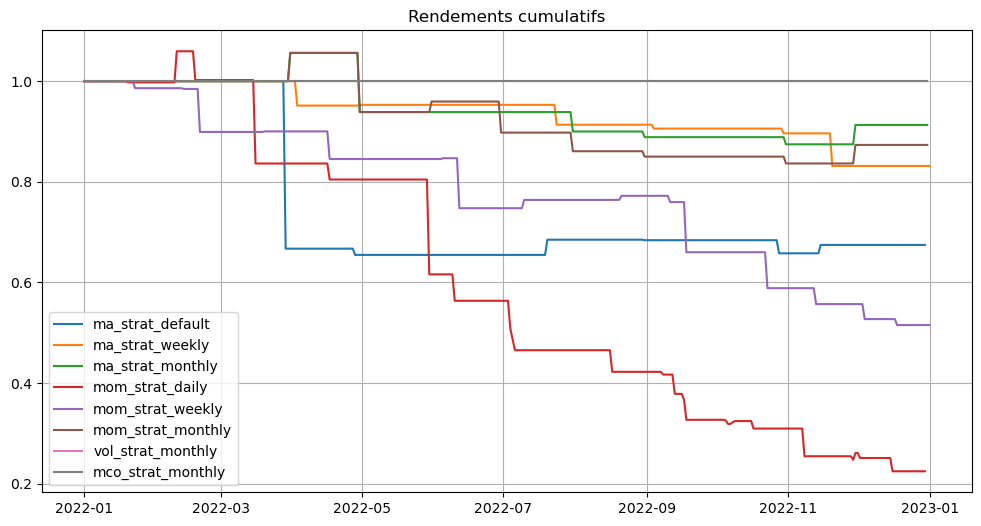

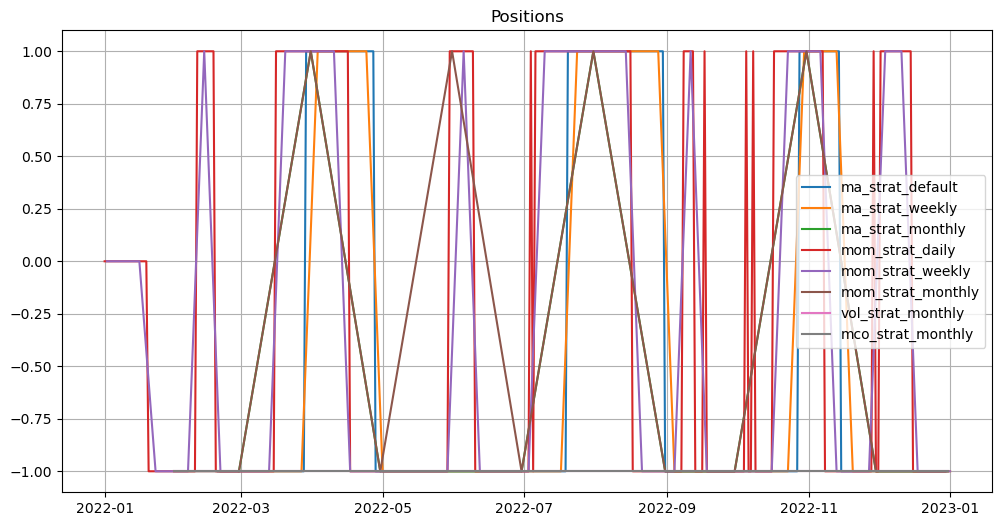

In [5]:
# Visualize results
backend = 'matplotlib' # 'plotly' # 'matplotlib' # 'seaborn'

# Plot individual strategies
manager.plot_all_strategies(backend=backend)


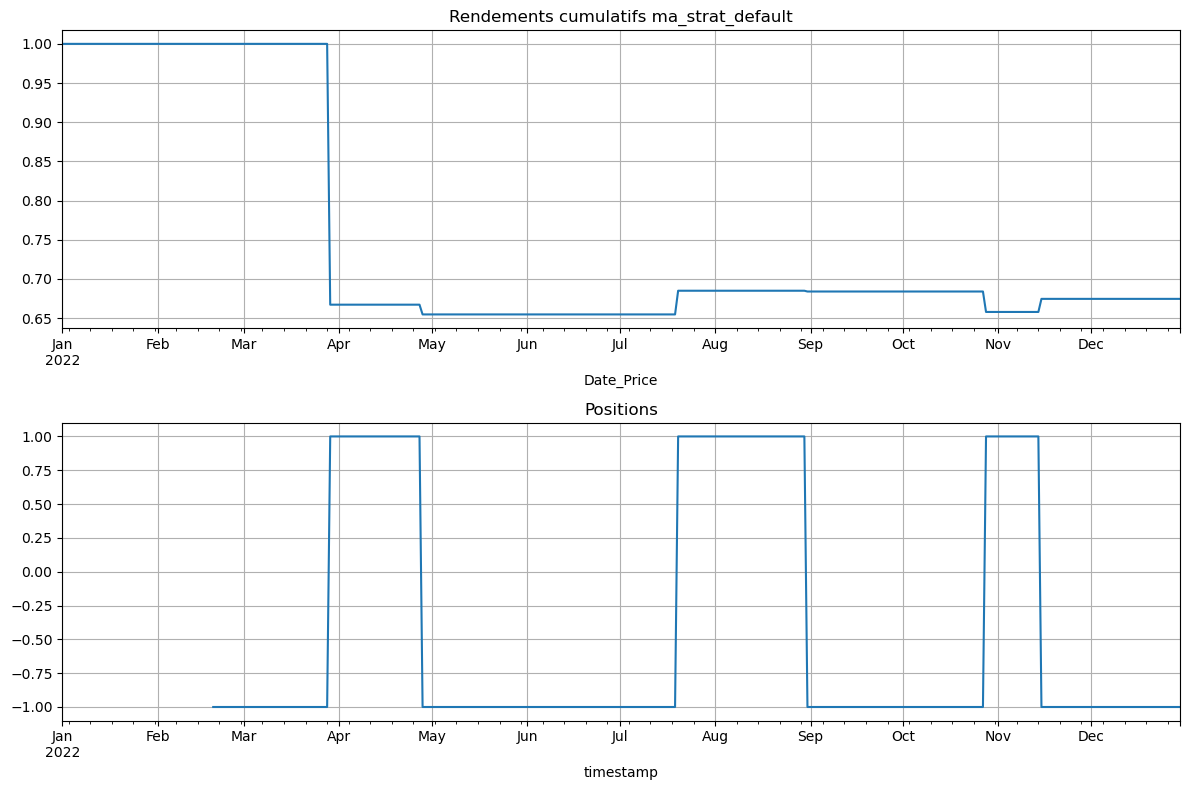

In [6]:
# Plot individual strategies
manager.plot_strategy(strategy_name="ma_strat_default",backend=backend)

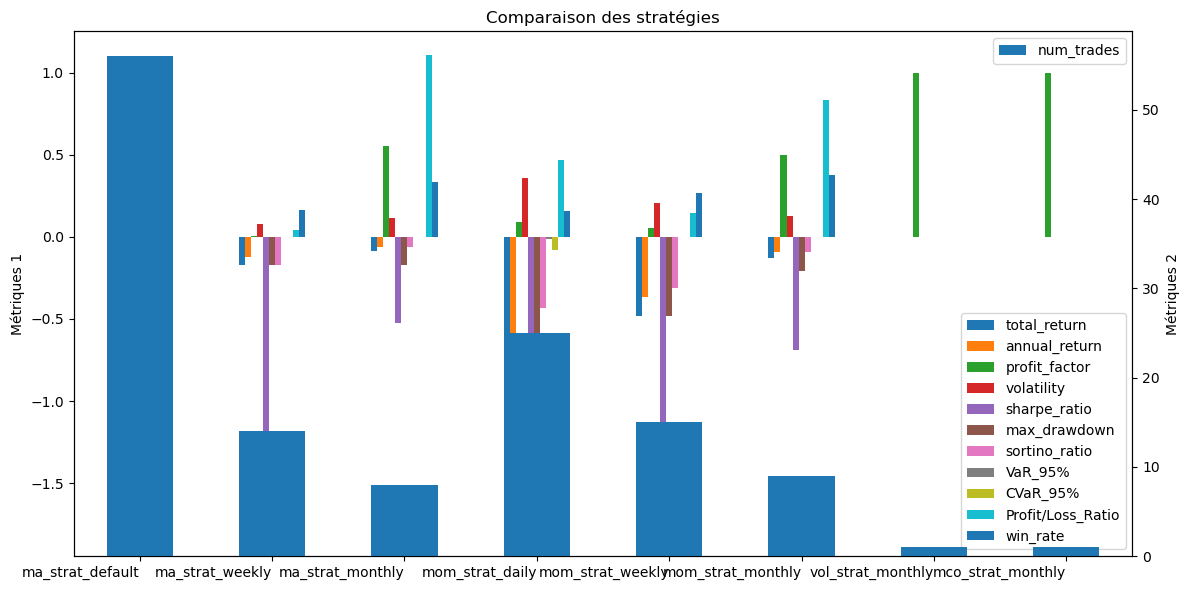

In [7]:
# Compare all strategies
manager.compare_strategies(backend=backend)
